In [1]:
import utils

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import logging

In [2]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.1.0
	• tf.keras version: 2.2.4-tf
	• Running on GPU


In [4]:
basedir = os.path.join("C:\\Users\\aktas\\Desktop\\VIBOT\\3.semester\\Meta-Learning\\project_final\\metacovid-siamese-neural-network", "dataset", "siamese") 

train_image_list, train_y_list = utils.load_images(basedir, 'train', (100,100))
print("The train set contains",len(train_image_list)) 

valid_image_list, valid_y_list = utils.load_images(basedir, 'validation', (100,100))   
print("The valid set contains", len(valid_image_list))  

test_image_list, test_y_list = utils.load_images(basedir, 'test', (100,100))   
print("The test set contains", len(test_image_list)) 

Found 30 images belonging to 3 classes.
The train set contains 30
Found 30 images belonging to 3 classes.
The valid set contains 30
Found 648 images belonging to 3 classes.
The test set contains 648


In [5]:
# make train pairs
pairs_train, labels_train = utils.make_pairs(train_image_list, train_y_list)

# make validation pairs
pairs_val, labels_val = utils.make_pairs(valid_image_list, valid_y_list)

# make test pairs
pairs_test, labels_test = utils.make_pairs(test_image_list, test_y_list)

x_train_1 = pairs_train[:, 0]  
x_train_2 = pairs_train[:, 1]
print("number of pairs for training", np.shape(x_train_1)[0]) 

x_val_1 = pairs_val[:, 0] 
x_val_2 = pairs_val[:, 1]
print("number of pairs for validation", np.shape(x_val_1)[0]) 

x_test_1 = pairs_test[:, 0] 
x_test_2 = pairs_test[:, 1]
print("number of pairs for test", np.shape(x_test_1)[0]) 

number of pairs for training 60
number of pairs for validation 60
number of pairs for test 1296


In [6]:
tf.compat.v1.reset_default_graph()

SIAMESE_MODEL_FNAME = 'siamese_network.h5'
EMBEDDING_MODEL_FNAME = 'embedding_network.h5'

input_1 = Input((100,100,3))
input_2 = Input((100,100,3))

embedding_network = tf.keras.models.load_model(EMBEDDING_MODEL_FNAME)
embedding_network.trainable = False

model = tf.keras.Sequential() 
for layer in embedding_network.layers:  
    model.add(layer) 

model.add(Flatten(name='flat'))
model.add(Dense(5120, name='den', activation='sigmoid', kernel_regularizer='l2')) 
 
output_1 = model(input_1) 
output_2 = model(input_2) 
 
merge_layer = Lambda(utils.manhattan_distance)([output_1, output_2]) 
output_layer = Dense(1, activation="sigmoid")(merge_layer) 
siamese = Model(inputs=[input_1, input_2], outputs=output_layer) 
siamese.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [7]:
""" callbacks """

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.0001)

checkpointer = ModelCheckpoint(filepath='siamese_network.h5', verbose=1, 
                                save_best_only=True)

In [10]:
""" train the model """

optimizer = Adam(learning_rate=0.0001)
siamese.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=optimizer, metrics=["accuracy"])
# siamese.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

siamese.summary()
history = siamese.fit([x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=1,
    epochs=100,   # 175 for contrastive 100 for cross ent
    callbacks = [checkpointer, early_stopping, reduce_lr]
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 5120)         14748995    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

Epoch 22/100
59/60 [============================>.] - ETA: 0s - loss: 0.5920 - accuracy: 0.9322
Epoch 00022: val_loss improved from 0.60146 to 0.60117, saving model to siamese_network.h5
60/60 [==============================] - 1s 21ms/sample - loss: 0.5940 - accuracy: 0.9333 - val_loss: 0.6012 - val_accuracy: 0.8333
Epoch 23/100
55/60 [==========================>...] - ETA: 0s - loss: 0.5909 - accuracy: 0.9636
Epoch 00023: val_loss improved from 0.60117 to 0.60078, saving model to siamese_network.h5
60/60 [==============================] - 1s 22ms/sample - loss: 0.5938 - accuracy: 0.9333 - val_loss: 0.6008 - val_accuracy: 0.8333
Epoch 24/100
58/60 [============================>.] - ETA: 0s - loss: 0.5935 - accuracy: 0.9310
Epoch 00024: val_loss improved from 0.60078 to 0.60058, saving model to siamese_network.h5
60/60 [==============================] - 1s 21ms/sample - loss: 0.5934 - accuracy: 0.9333 - val_loss: 0.6006 - val_accuracy: 0.8333
Epoch 25/100
54/60 [=======================

Epoch 48/100
59/60 [============================>.] - ETA: 0s - loss: 0.5850 - accuracy: 0.9322
Epoch 00048: val_loss improved from 0.59431 to 0.59420, saving model to siamese_network.h5
60/60 [==============================] - 1s 21ms/sample - loss: 0.5869 - accuracy: 0.9333 - val_loss: 0.5942 - val_accuracy: 0.8667
Epoch 49/100
54/60 [==========================>...] - ETA: 0s - loss: 0.5906 - accuracy: 0.9444
Epoch 00049: val_loss improved from 0.59420 to 0.59364, saving model to siamese_network.h5
60/60 [==============================] - 1s 21ms/sample - loss: 0.5867 - accuracy: 0.9333 - val_loss: 0.5936 - val_accuracy: 0.8667
Epoch 50/100
59/60 [============================>.] - ETA: 0s - loss: 0.5845 - accuracy: 0.9661
Epoch 00050: val_loss did not improve from 0.59364
60/60 [==============================] - 1s 20ms/sample - loss: 0.5864 - accuracy: 0.9667 - val_loss: 0.5937 - val_accuracy: 0.8667
Epoch 51/100
58/60 [============================>.] - ETA: 0s - loss: 0.5863 - accu

58/60 [============================>.] - ETA: 0s - loss: 0.5845 - accuracy: 0.9828
Epoch 00074: val_loss improved from 0.58832 to 0.58822, saving model to siamese_network.h5
60/60 [==============================] - 1s 21ms/sample - loss: 0.5810 - accuracy: 0.9667 - val_loss: 0.5882 - val_accuracy: 0.8667
Epoch 75/100
58/60 [============================>.] - ETA: 0s - loss: 0.5851 - accuracy: 0.9655
Epoch 00075: val_loss improved from 0.58822 to 0.58801, saving model to siamese_network.h5
60/60 [==============================] - 1s 21ms/sample - loss: 0.5807 - accuracy: 0.9667 - val_loss: 0.5880 - val_accuracy: 0.8667
Epoch 76/100
56/60 [===========================>..] - ETA: 0s - loss: 0.5763 - accuracy: 0.9643
Epoch 00076: val_loss improved from 0.58801 to 0.58771, saving model to siamese_network.h5
60/60 [==============================] - 1s 21ms/sample - loss: 0.5805 - accuracy: 0.9667 - val_loss: 0.5877 - val_accuracy: 0.8667
Epoch 77/100
59/60 [============================>.] - ET

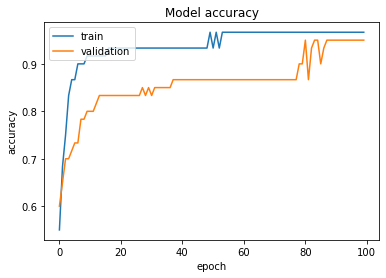

In [22]:
# Plot the accuracy
utils.plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

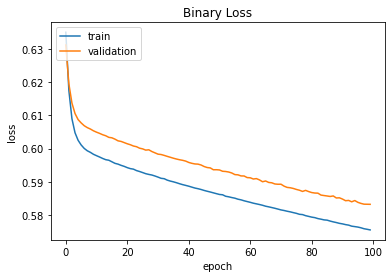

In [23]:
# Plot the cross entropy binary loss
utils.plt_metric(history=history.history, metric="loss", title="Binary Loss")

In [24]:
""" Test the model """
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

1296/1296 [==============================] - 3s 2ms/sample - loss: 0.5848 - accuracy: 0.9290
test loss, test acc: [0.5847931128961069, 0.92901236]


In [25]:
Y_pred = siamese.predict([x_test_1, x_test_2]).squeeze()
Y_pred

array([0.35574326, 0.02214266, 0.5947736 , ..., 0.01073599, 0.58562875,
       0.0073857 ], dtype=float32)

In [26]:
Y_pred.mean()

0.27663705

In [27]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = Y_pred > Y_pred.mean()
y_pred

array([ True, False,  True, ..., False,  True, False])

In [28]:
y_test = labels_test
y_test

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [19]:
print("\nEvaluate on test data")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("ROC AUC:", roc_auc_score(y_test, y_pred, average='weighted'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))


Evaluate on test data
Accuracy: 0.9683641975308642
Precision: 0.9694385632413001
Recall: 0.9683641975308642
ROC AUC: 0.9683641975308642
F1: 0.9683460865990928


In [29]:
cm = confusion_matrix(y_test, y_pred)    
# cm_display = ConfusionMatrixDisplay(cm, labels_test).plot()

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
print("Specificity:", specificity)

Specificity: 0.9922839506172839


In [30]:
tf.keras.backend.clear_session()